In [1]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')


from math import sqrt
import pandas as pd

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP




In [2]:
from clsar.dataset import LSSInhibitor
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures

In [3]:
! rm -r ../../tmp/data*

In [4]:
for dataset_name in LSSInhibitor.names.keys():
    print(dataset_name)

for dataset_name in MoleculeNet.names.keys():
    print(dataset_name)

mglur2
usp7
mth1
rip2
pkci
phgdh
rorg
ido1
klk5
notum
eaat3
esol
freesolv
lipo
pcba
muv
hiv
bace
bbbp
tox21
toxcast
sider
clintox


In [5]:
dataset_name = 'mth1'
Dataset =  LSSInhibitor # MoleculeNet
epochs = 500

In [6]:
pre_transform = Gen115AtomFeatures()
in_channels = 115
path = '../../tmp/data1'

# use the attentiveFP node and edge features during the mol-2-graph transoformation
#dataset = LSSInhibitor(path, name=dataset_name, pre_transform=GenAttentiveFeatures()).shuffle()
dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

batch_size = 16

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=in_channels, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=2, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)

def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

history1 = []
for epoch in range(1, epochs):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')
    
    history1.append({'Epoch':epoch, 'train_rmse':train_rmse, 'val_rmse':val_rmse, 'test_rmse':test_rmse})
    
pd.DataFrame(history1).to_csv('./%s_%s.csv' % (dataset_name, in_channels))

Processing...
Done!


Epoch: 001, Loss: 7.6451 Val: 6.8603 Test: 6.0837
Epoch: 002, Loss: 6.8399 Val: 6.0823 Test: 5.1028
Epoch: 003, Loss: 5.9028 Val: 4.9546 Test: 4.1032
Epoch: 004, Loss: 4.6822 Val: 3.5161 Test: 2.5569
Epoch: 005, Loss: 3.0499 Val: 2.5869 Test: 1.8515
Epoch: 006, Loss: 2.0841 Val: 3.1145 Test: 3.3669
Epoch: 007, Loss: 2.9629 Val: 3.5096 Test: 3.5127
Epoch: 008, Loss: 3.2720 Val: 2.8784 Test: 2.5759
Epoch: 009, Loss: 2.7432 Val: 2.6820 Test: 2.2527
Epoch: 010, Loss: 2.2736 Val: 2.5615 Test: 1.8807
Epoch: 011, Loss: 2.1331 Val: 2.3848 Test: 1.7909
Epoch: 012, Loss: 2.1919 Val: 2.8250 Test: 1.9874
Epoch: 013, Loss: 2.4055 Val: 2.7717 Test: 1.7598
Epoch: 014, Loss: 2.7034 Val: 2.5981 Test: 1.7339
Epoch: 015, Loss: 2.1374 Val: 1.9987 Test: 1.8802
Epoch: 016, Loss: 1.8688 Val: 2.3916 Test: 1.7878
Epoch: 017, Loss: 1.9262 Val: 1.7170 Test: 1.7614
Epoch: 018, Loss: 1.8629 Val: 2.2938 Test: 2.0433
Epoch: 019, Loss: 1.9562 Val: 1.9477 Test: 2.0105
Epoch: 020, Loss: 1.4327 Val: 2.3634 Test: 1.7725


In [7]:
pre_transform = GenAttentiveFeatures()
in_channels = 39
path = '../../tmp/data2'

# use the attentiveFP node and edge features during the mol-2-graph transoformation
#dataset = LSSInhibitor(path, name=dataset_name, pre_transform=GenAttentiveFeatures()).shuffle()
dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

batch_size = 16

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=in_channels, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=2, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)

def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

history2 = []
for epoch in range(1, epochs):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')
    
    history2.append({'Epoch':epoch, 'train_rmse':train_rmse, 'val_rmse':val_rmse, 'test_rmse':test_rmse})
    
pd.DataFrame(history2).to_csv('./%s_%s.csv' % (dataset_name, in_channels))

Processing...
Done!


Epoch: 001, Loss: 7.7170 Val: 6.4590 Test: 7.5136
Epoch: 002, Loss: 7.1241 Val: 5.8945 Test: 6.9739
Epoch: 003, Loss: 6.4305 Val: 5.3131 Test: 6.1858
Epoch: 004, Loss: 5.6450 Val: 4.2753 Test: 5.3331
Epoch: 005, Loss: 4.3476 Val: 3.1015 Test: 3.9304
Epoch: 006, Loss: 3.0698 Val: 2.2772 Test: 2.6619
Epoch: 007, Loss: 2.2979 Val: 2.2453 Test: 2.0036
Epoch: 008, Loss: 2.6432 Val: 2.2715 Test: 1.6837
Epoch: 009, Loss: 2.9952 Val: 1.8959 Test: 1.7872
Epoch: 010, Loss: 2.7122 Val: 1.8822 Test: 1.8094
Epoch: 011, Loss: 1.8283 Val: 1.7601 Test: 2.3494
Epoch: 012, Loss: 1.9279 Val: 1.9518 Test: 2.5675
Epoch: 013, Loss: 2.1564 Val: 2.2236 Test: 2.8487
Epoch: 014, Loss: 2.4333 Val: 2.2066 Test: 3.2400
Epoch: 015, Loss: 2.2006 Val: 2.0123 Test: 2.4348
Epoch: 016, Loss: 2.1911 Val: 1.6456 Test: 2.3044
Epoch: 017, Loss: 1.9595 Val: 1.5419 Test: 2.1788
Epoch: 018, Loss: 1.4799 Val: 1.5304 Test: 1.6818
Epoch: 019, Loss: 1.5395 Val: 1.2666 Test: 1.2421
Epoch: 020, Loss: 1.7881 Val: 1.3982 Test: 1.3937


In [425]:
class ACNet_PNA(ACNet_Base):
    r"""The Graph Neural Network from the `"Principal Neighbourhood Aggregation
    for Graph Nets" <https://arxiv.org/abs/2004.05718>`_ paper, using the
    :class:`~torch_geometric.nn.conv.PNAConv` operator for message passing.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each out sample.
        edge_dim (int): Edge feature dimensionality. 
        hidden_channels (int, optional): Size of each hidden sample. (default: :int:64)
        num_layers (int, optional): Number of message passing layers. (default: :int:2)
        dropout_p (float, optional): Dropout probability. (default: :obj:`0.1`) of ACNet, different from dropout in GATConv layer
        batch_norms (torch.nn.Module, optional, say torch.nn.BatchNorm1d): The normalization operator to use. (default: :obj:`None`)
        global_pool: (torch_geometric.nn.Module, optional): the global-pooling-layer. (default: :obj: torch_geometric.nn.global_mean_pool)
        **kwargs (optional): Additional arguments of the underlying:class:`torch_geometric.nn.conv.MessagePassing` layers.
    """
    
    def init_conv(self, in_channels, out_channels, edge_dim, **kwargs): 
        return PNAConv(in_channels, out_channels, edge_dim = edge_dim,  **kwargs)

In [451]:
pre_transform = GenAttentiveFeatures()
in_channels = 39
path = '../../tmp/data2'

# use the attentiveFP node and edge features during the mol-2-graph transoformation
#dataset = LSSInhibitor(path, name=dataset_name, pre_transform=GenAttentiveFeatures()).shuffle()
dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

batch_size = 16

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = ACNet_PNA(in_channels=in_channels, out_channels=1,  
                  aggregators = ['mean', 'max', 'sum'], 
                  scalers = ['identity', 'amplification'], deg = torch.tensor([1, 2, 3]),
                  hidden_channels=64, edge_dim=10,
                  num_layers = 2).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)

def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

history3 = []
for epoch in range(1, epochs):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')
    
    history3.append({'Epoch':epoch, 'train_rmse':train_rmse, 'val_rmse':val_rmse, 'test_rmse':test_rmse})
    
pd.DataFrame(history3).to_csv('./ACNet-GCN_%s_%s.csv' % (dataset_name, in_channels))

Epoch: 001, Loss: 7.5447 Val: 8.0712 Test: 7.2729
Epoch: 002, Loss: 7.4349 Val: 7.9697 Test: 7.1668
Epoch: 003, Loss: 7.3278 Val: 7.8564 Test: 7.0634
Epoch: 004, Loss: 7.2122 Val: 7.7256 Test: 6.9289
Epoch: 005, Loss: 7.0725 Val: 7.5575 Test: 6.7599
Epoch: 006, Loss: 6.8917 Val: 7.3596 Test: 6.5437
Epoch: 007, Loss: 6.6626 Val: 7.0725 Test: 6.2709
Epoch: 008, Loss: 6.3607 Val: 6.6975 Test: 5.9183
Epoch: 009, Loss: 5.9735 Val: 6.2315 Test: 5.4180
Epoch: 010, Loss: 5.4181 Val: 5.5287 Test: 4.7459
Epoch: 011, Loss: 4.6751 Val: 4.6201 Test: 3.8517
Epoch: 012, Loss: 3.7916 Val: 3.5136 Test: 2.6876
Epoch: 013, Loss: 2.6669 Val: 2.2091 Test: 1.4219
Epoch: 014, Loss: 1.9271 Val: 1.7003 Test: 1.7866
Epoch: 015, Loss: 2.5675 Val: 2.0210 Test: 2.5375
Epoch: 016, Loss: 3.0473 Val: 1.8064 Test: 1.9207
Epoch: 017, Loss: 2.7408 Val: 1.6413 Test: 1.3989
Epoch: 018, Loss: 1.9185 Val: 1.7595 Test: 1.3164
Epoch: 019, Loss: 1.7610 Val: 2.0923 Test: 1.2653
Epoch: 020, Loss: 1.8629 Val: 2.4665 Test: 1.6123


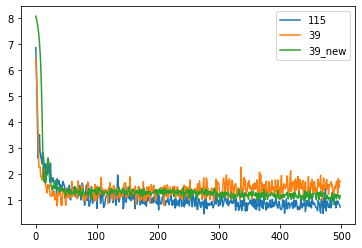

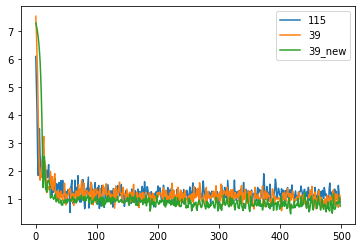

In [453]:
df1 = pd.DataFrame(history1)
df2 = pd.DataFrame(history2)

df3 = pd.DataFrame(history3)
ax = df1.val_rmse.to_frame('115').join(df2.val_rmse.to_frame('39')).join(df3.val_rmse.to_frame('39_new')).plot()
ax = df1.test_rmse.to_frame('115').join(df2.test_rmse.to_frame('39')).join(df3.test_rmse.to_frame('39_new')).plot()

In [454]:

#ax.set_ylim(0.3,1.5)

In [399]:
GINEConv()

TypeError: __init__() missing 1 required positional argument: 'nn'

In [ ]:
MLP([in_channels, out_channels, out_channels], batch_norm=True)

In [8]:
for data in train_loader:
    data

In [9]:
data.num_graphs

12

In [10]:
data.y


tensor([[ 9.1000],
        [ 8.0000],
        [ 7.9200],
        [ 7.5200],
        [ 6.9200],
        [ 7.4000],
        [10.0000],
        [ 6.4800],
        [ 8.3000],
        [ 5.0000],
        [ 5.5700],
        [ 8.5100]])

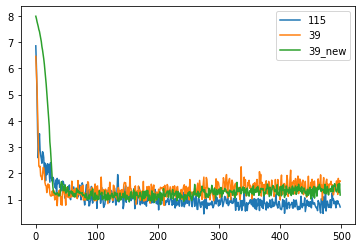

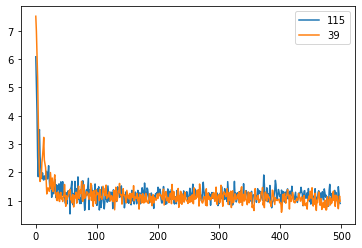

In [14]:
model = AttentiveFP(in_channels=in_channels, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=2, num_timesteps=2,
                    dropout=0.2)
out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)

In [15]:
from torchviz import make_dot

In [16]:
make_dot(out, params=dict(list(model.named_parameters()))).render("./rnn_torchviz", format="png")

'rnn_torchviz.png'

In [17]:
ls


data_model_test.ipynb  rnn_torchviz2          rnn_torchviz.png
env_test.ipynb         rnn_torchviz2.pdf      rorg_115.csv
mth1_115.csv           rnn_torchviz2.pdf.pdf  rorg_39.csv
mth1_39.csv            rnn_torchviz2.png
rnn_torchviz           rnn_torchviz2.png.png


In [455]:
SAGEConv()

NameError: name 'GraphSAGE' is not defined

In [185]:
64 % 3

1

In [267]:
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn import Sequential, GCNConv, GATConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool, global_max_pool

# form mypool import pharmacophore_pool

in_channels = 39
out_channels = 1
edge_dim = 10

jk_mode = 'cat'

clsarnet = Sequential('x, edge_index, edge_attr, batch', 
                      [(Dropout(p=0.5), 'x -> x'),
                       (GATConv(in_channels, 64, heads=3, concat=False, edge_dim=edge_dim), 'x, edge_index, edge_attr -> x1'),
                       ReLU(inplace=True),
                       (GATConv(64, 64,  heads=3, concat=False, edge_dim=edge_dim), 'x1, edge_index, edge_attr -> x2'),
                       ReLU(inplace=True),
                       (lambda x1, x2: [x1, x2, x1, x2], 'x1, x2 -> xs'),
                       (JumpingKnowledge(jk_mode, 64, num_layers=2), 'xs -> x'),
                       (global_mean_pool, 'x, batch -> x'),
                       ]) #Linear(2 * 64, out_channels),


In [268]:
out = clsarnet(data.x.float(), data.edge_index, data.edge_attr, data.batch)

In [269]:
out.shape

torch.Size([12, 256])

In [260]:
global_mean_pool(data.x, data.batch).shape, global_max_pool(data.x, data.batch).shape

(torch.Size([12, 39]), torch.Size([12, 39]))

In [245]:
data.x.shape, data.batch.shape

(torch.Size([224, 39]), torch.Size([224]))

In [244]:
global_mean_pool(data.x, data.batch).shape

torch.Size([12, 39])

In [254]:
pd.DataFrame(global_mean_pool(data.x, data.batch).numpy())

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,0.714286,0.190476,0.095238,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.428571,0.428571,0.285714,0.190476,0.095238,0.0,0.047619,0.0,0.047619
1,0.0,0.684211,0.210526,0.000000,0.0,0.0,0.0,0.0,0.105263,0.0,...,0.0,0.631579,0.526316,0.315789,0.157895,0.000000,0.0,0.000000,0.0,0.000000
2,0.0,0.750000,0.150000,0.050000,0.0,0.0,0.0,0.0,0.050000,0.0,...,0.0,0.750000,0.500000,0.450000,0.000000,0.050000,0.0,0.000000,0.0,0.000000
3,0.0,0.750000,0.250000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.750000,0.400000,0.450000,0.150000,0.000000,0.0,0.050000,0.0,0.000000
4,0.0,0.666667,0.266667,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.400000,0.400000,0.200000,0.200000,0.200000,0.0,0.000000,0.0,0.000000
5,0.0,0.789474,0.157895,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.789474,0.421053,0.473684,0.105263,0.000000,0.0,0.000000,0.0,0.000000
6,0.0,0.740741,0.185185,0.074074,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.555556,0.407407,0.407407,0.185185,0.000000,0.0,0.037037,0.0,0.000000
7,0.0,0.642857,0.285714,0.071429,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.428571,0.357143,0.285714,0.214286,0.142857,0.0,0.000000,0.0,0.000000
8,0.0,0.736842,0.210526,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.473684,0.421053,0.263158,0.157895,0.157895,0.0,0.052632,0.0,0.000000
9,0.0,0.714286,0.142857,0.142857,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.642857,0.500000,0.357143,0.071429,0.071429,0.0,0.000000,0.0,0.000000


In [255]:
in_channels

39

In [152]:
make_dot(out).render("./clsarnet-new2.pdf", format="pdf")

'clsarnet-new2.pdf.pdf'

In [153]:
ot = GATConv(in_channels, 64, heads=6, concat=True, edge_dim=edge_dim)

In [131]:
ot.out_channels

64

In [300]:
from torch_geometric.nn import Sequential, GCNConv, NNConv, GATConv, JumpingKnowledge

g = GATConv(39, 128, edge_dim =10,  heads=1, concat=False)

In [301]:
g(x = data.x, edge_index = data.edge_index, edge_attr = data.edge_attr)

tensor([[-3.3411e-02, -3.9456e-02, -1.5457e-01,  ..., -1.1791e-01,
         -2.5572e-01,  2.0670e-01],
        [ 3.4787e-05, -1.4142e-01, -2.0048e-01,  ..., -1.6397e-01,
         -2.5416e-01,  2.3350e-01],
        [ 6.3165e-02, -6.2352e-02, -1.5400e-01,  ..., -1.5621e-01,
         -1.8206e-01,  2.3400e-01],
        ...,
        [ 1.2581e-01,  1.2803e-01, -1.2357e-01,  ..., -1.0917e-01,
         -8.0057e-02,  1.4057e-01],
        [ 1.6762e-01, -9.4615e-02, -1.5052e-01,  ..., -8.2527e-02,
         -7.3151e-02,  1.9459e-01],
        [ 1.3471e-01, -2.3084e-01, -1.7661e-01,  ..., -1.0784e-01,
         -1.4055e-01,  2.1582e-01]], grad_fn=<AddBackward0>)

In [323]:
nn = torch.nn.Linear(10, 39)
layer = NNConv(39, 2, nn=nn, aggr='mean')
layer(x = data.x, edge_index = data.edge_index, edge_attr = data.edge_attr)

RuntimeError: The size of tensor a (490) must match the size of tensor b (245) at non-singleton dimension 0

In [318]:
data.edge_attr.shape

torch.Size([490, 10])

In [378]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=in_channels, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=2, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                             weight_decay=10**-5)

def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

history2 = []
for epoch in range(1, epochs):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')
    
    history2.append({'Epoch':epoch, 'train_rmse':train_rmse, 'val_rmse':val_rmse, 'test_rmse':test_rmse})
    
pd.DataFrame(history2).to_csv('./%s_%s.csv' % (dataset_name, in_channels))

In [354]:
data.edge_attr.shape,  data.edge_index.shape

(torch.Size([490, 10]), torch.Size([2, 490]))

In [363]:
m = nn.Linear(10, 3)
input = torch.randn(490, 10)
output = m(input)

In [364]:
output.shape

torch.Size([490, 3])

/tmp/ipykernel_8971/3926009216.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  in_degrees = np.zeros(num_of_nodes, dtype=np.int)
/tmp/ipykernel_8971/3926009216.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

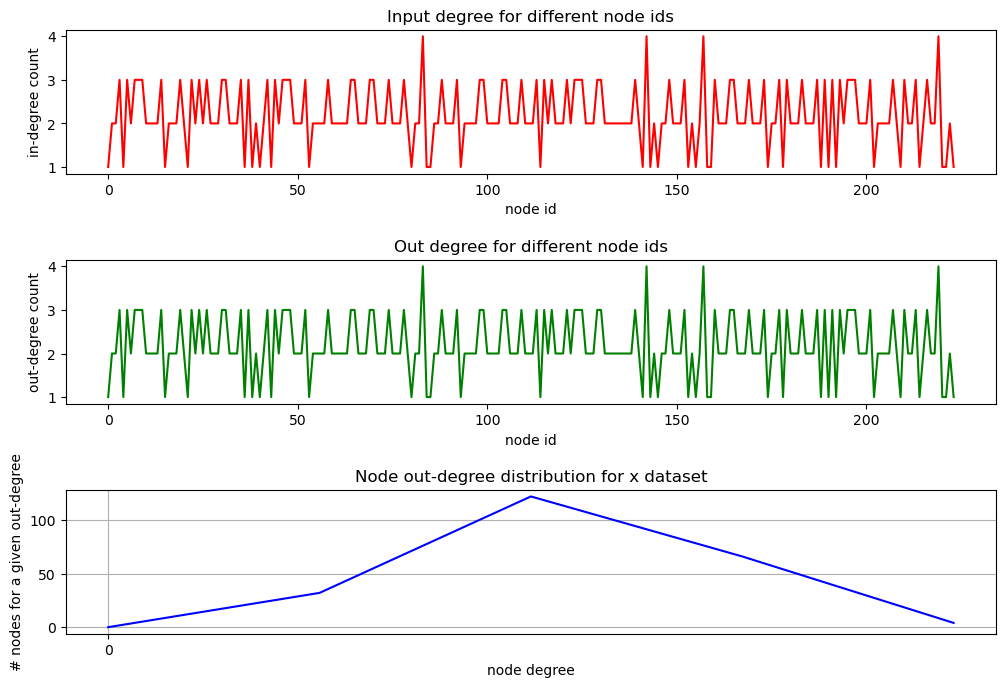

/tmp/ipykernel_8971/1456744941.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  in_degrees = np.zeros(num_of_nodes, dtype=np.int)
/tmp/ipykernel_8971/1456744941.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

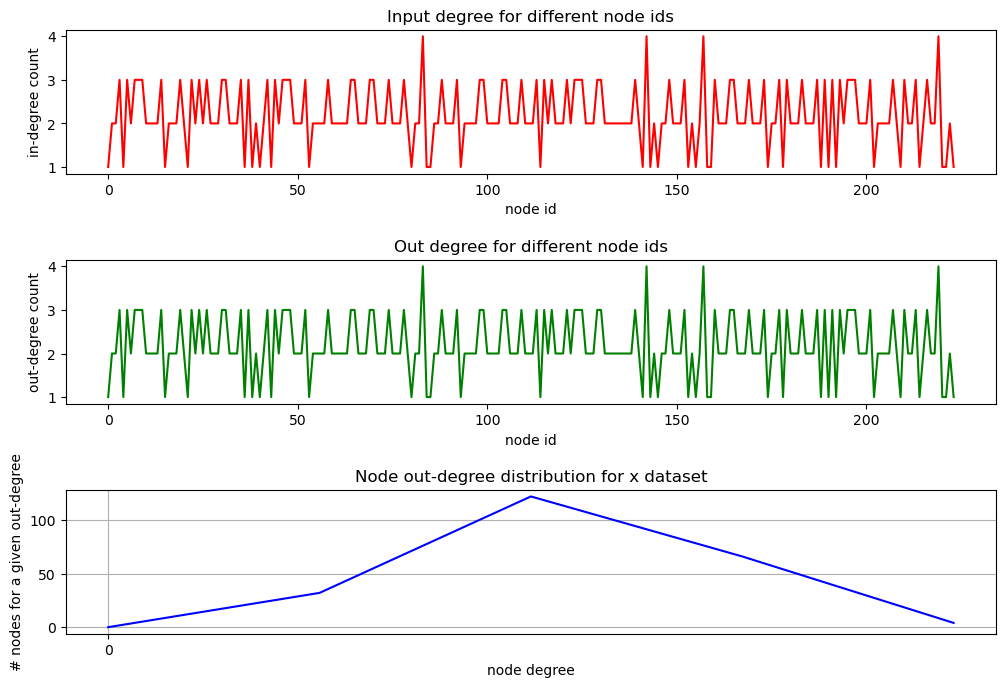

In [442]:
in_degrees, out_degrees = plot_in_out_degree_distributions(data.edge_index, data.x.shape[0], 'x')

In [447]:
in_degrees

array([1, 2, 2, 3, 1, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 1,
       3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 1, 3, 1, 2, 1, 2, 3, 1,
       3, 2, 3, 3, 3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3,
       2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 2, 2, 4, 1, 1, 2, 2,
       3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3,
       2, 2, 2, 3, 1, 3, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 4, 1, 2, 1, 2, 2, 3, 2, 2, 2, 3, 1,
       2, 1, 2, 4, 1, 1, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 1, 2,
       2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 2, 3, 1, 3, 1, 3, 1, 3, 2, 3, 3, 3,
       2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 1, 3, 2, 2, 3, 1, 2, 3, 2, 2, 4,
       1, 1, 2, 1])

In [445]:
data.x.shape

torch.Size([224, 39])